In [49]:
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torcheval.metrics.functional import r2_score as r2

### GPU ###
# I have majority access to GPU on afternoons on even days, and mornings on odd days

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

### DATA ###
# define full path 
path_to_data = "/home/kim/data/aerosols/aerosol_emulation_data/"

# NP for now
x_train = np.load(path_to_data + 'X_train.npy')
y_train = np.load(path_to_data + 'y_train.npy')

x_test = np.load(path_to_data + 'X_test.npy')
y_test = np.load(path_to_data + 'y_test.npy')

x_val = np.load(path_to_data + 'X_val.npy')
y_val = np.load(path_to_data + 'y_val.npy')

# Select the correct 24 columns
# x train, val, test
x_train_24 = x_train[:, 8:]
x_val_24 = x_val[:, 8:]
x_test_24 = x_test[:, 8:]

# y train, val, test
y_train_24 = y_train[:, :24]
y_val_24 = y_val[:, :24]
y_test_24 = y_test[:, :24]

# How much has it changes between x (at t = 0)  and y (at t = 1)
y_delta_train_24 = y_train_24 - x_train_24
y_delta_val_24 = y_val_24 - x_val_24
y_delta_test_24 = y_test_24 - x_test_24

### SPECIES ###
# Define column indices for each of the components (24 column version)
so4_indices = [0, 1, 2, 3, 4]
bc_indices = [5, 6, 7, 8]
oc_indices = [9, 10, 11, 12]
du_indices = [13, 14, 15, 16]

# Define aerosol species and their corresponding indices
species_indices = {
    'so4': so4_indices,
    'bc': bc_indices,
    'oc': oc_indices,
    'du': du_indices
}

### SPLIT ###
data_split = ['train', 'val', 'test']

# What are these indices?!
extra_indices = [17, 18, 19, 20, 21, 22, 23] 

##########################
### Normalise the data ###
##########################

def arcsinh_x_per_species(eps = 1e-5):
    # This transformation can be easily reversed and preserved the zero
    # Iterate over species
    # We arcsinh (universal) and normalise by species variance
    for species, indices in species_indices.items():
        # Iterate over data splits (train, val, test)
        for split in data_split:
            # Fetch the data
            x_split_species = globals()[f'x_{split}_24'][:, indices]
            # Make tensor
            x_split_species = torch.tensor(x_split_species).clone()

            # STEP 1: Clamp negative values as these should not be allowed
            nonneg_split_species = torch.clamp_min(x_split_species, min = 0.0)

            # STEP 2: Arcsinh
            arcsinh_split_species = torch.arcsinh(nonneg_split_species)

            # STEP 3: Scale to unit variance i.e. unit std
            arcsinh_unitvar_split_species = arcsinh_split_species / torch.std(arcsinh_split_species)
            # globals()[f'x_{split}_{species}_arcsinh_unitvar'] = arcsinh_split_species_unitvar

            # SAVE
            globals()[f'x_{split}_{species}_arcsinh'] = arcsinh_split_species
            # option
            globals()[f'x_{split}_{species}_arcsinh_unitvar'] = arcsinh_unitvar_split_species


# Call
arcsinh_x_per_species()

def arcsin_y_delta_per_species(eps = 1e-5):
    # Iterate over species
    for species, indices in species_indices.items():
        # Iterate over data splits (train, val, test)
        for split in data_split:
            # Fetch the data
            y_delta_split_species = globals()[f'y_delta_{split}_24'][:, indices]
            # Make tensor
            y_delta_split_species = torch.tensor(y_delta_split_species).clone()
            # We use this variable for og domain comparison
            globals()[f'y_delta_{split}_{species}'] = y_delta_split_species

            # STEP 1: scale to unit var
            y_delta_split_species_unitvar = y_delta_split_species / torch.std(y_delta_split_species)
            # globals()[f'y_delta_{split}_{species}_unitvar'] = y_delta_split_species_unitvar

            # export std to global namespace for renormalization
            globals()[f'std_y_delta_{split}_{species}'] = torch.std(y_delta_split_species)

            # STEP 2: Arcsin
            arcsinh_y_delta_split_species = torch.asinh(y_delta_split_species)
            arcsinh_unitvar_y_delta_split_species = torch.asinh(y_delta_split_species_unitvar)

            # SAVE both options
            globals()[f'y_delta_{split}_{species}_arcsinh'] = arcsinh_y_delta_split_species
            globals()[f'y_delta_{split}_{species}_arcsinh_unitvar'] = arcsinh_unitvar_y_delta_split_species

# Call
arcsin_y_delta_per_species()

# Helper
def n_random_row_incides(x, n = 5000):
    """Returns n random rows from x"""
    # Default is 5000
    indices = np.random.choice(x.shape[0], n, replace = False)
    return indices

Using device: cuda:0


# SO4 model

In [50]:
#############
### MODEL ###
#############

class TransitionMatrix(nn.Module):
    def __init__(self, in_features, out_features, width, depth = 2, bias = 5.0):
        super(TransitionMatrix, self).__init__()
        # this is the self transition bias, added to the logits (prior knowledge), high val
        self.bias = bias
        self.out_features = out_features
        # define this once and reuse
        self.transition_identity = torch.eye(out_features).unsqueeze(0)
        self.eps = 1e-8

        # the first layer takes in_features * 2 as input, because we are concatenating the inputthe raltive inputs
        self.fc_in = nn.Linear(in_features = in_features * 2, out_features = width)

        self.hidden_layers = nn.ModuleList()
        for _ in range(depth -1):
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Linear(in_features = width, out_features = width))
            self.hidden_layers.append(nn.ReLU())

        # for the transition matrix, we want to have a square matrix, 1 for scale factor
        self.fc_out = nn.Linear(in_features = width, out_features = (out_features * out_features) + 1)

        # Set all model parameters to double precision
        self.to(torch.float64)

    def forward(self, x):
        # x is shape(batch_size, in_features)
        # ensure double
        x = x.to(torch.float64)
        
        # Normalise the input to relative values (sum to 1), clamp to avoid div by zero
        x_relative = x / torch.clamp_min(x.sum(axis = -1), self.eps).unsqueeze(-1)

        # Concatenate the input with the relative input and pass into the first layer
        # shape(batch_size, in_features * 2)
        state = self.fc_in(torch.cat((x, x_relative), dim = -1))

        for layer in self.hidden_layers:
            state = layer(state)

        state = self.fc_out(state)

        # Divide the output into logits and scale factor
        logits_raw, scale_factor = state[:, :-1], state[:, -1]

        # Reshape to get (batch_size, out_features, out_features)
        logits = logits_raw.view(-1, self.out_features, self.out_features)

        if torch.isnan(logits).any():
            print("NaN detected at logits!")
        if torch.isinf(logits).any():
            print("Inf detected at logits!")

        # Add the bias to the diagonal (self transitions) with in-place operation
        logits.diagonal(dim1 = -2, dim2 = -1).add_(self.bias)

        # Apply softmax across each row so that columns (last dim) add to 1
        # rows add to 1 (From : To): 100% of the source are redistributed
        # Variance of a softmax is 1/N, variance of a arcsinh unit std is 1
        transition_matrix = F.softmax(logits, dim = -1)

        # Transition matrix without self-transitions
        # Repeat for bacth_size
        transition_matrix_no_diag = transition_matrix - self.transition_identity.repeat(transition_matrix.shape[0], 1, 1).to(device)

        # Multiply the input by the transition matrix without diagonal: bmm or matmul work
        deltas = torch.matmul(transition_matrix_no_diag, x.unsqueeze(-1)).squeeze(-1)

        # reshape scale factor to (batch_size, 1)
        # Scale of the estimated scale factor to account for smaller variance in softmax output (1/N) thus * N
        scaled_deltas = deltas * (scale_factor.unsqueeze(-1) * self.out_features)

        # correct delta numerical precision issue, but comp overhead
        corrected_scaled_deltas = scaled_deltas - scaled_deltas.mean(dim = (-1), keepdim = True)
        # print((deltas.mean(dim = (-1), keepdim = True)).shape)

        # return (batch_size, out_features)
        return corrected_scaled_deltas


############
### test ###
############

# need features to initialize the model: bc has 4 columns
in_feat = x_train_so4_arcsinh.shape[-1]
out_feat = y_delta_train_so4_arcsinh_unitvar.shape[-1]

model = TransitionMatrix(in_features = in_feat, out_features = in_feat, width = 2).double().to(device)

In [51]:
species = 'so4'

############
### test ###
############


# need features to initialize the model: bc has 4 columns
in_feat = globals()[f"x_train_{species}_arcsinh"].shape[-1]
out_feat = globals()[f"y_delta_train_{species}_arcsinh_unitvar"].shape[-1]

model = TransitionMatrix(in_features = in_feat, out_features = in_feat, width = 2).double().to(device)

In [52]:
model_path = f"models/arcsinh_transition_{species}.pth"

checkpoint = torch.load(model_path)
# print(checkpoint.keys())

model.load_state_dict(torch.load(model_path))
# Evaluate
model.eval()

# training did not use x_test_so4_arcsinh_unitvar yet
test_dataset = TensorDataset(x_test_so4_arcsinh, y_delta_test_so4_arcsinh_unitvar)
test_loader = DataLoader(test_dataset, batch_size = 256, shuffle = True)

r2_transformed = []
r2_og = []
rmse_transformed = []
rmse_og = []

for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
    # Move data to device
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    y_batch_og = torch.sinh(y_batch) * std_y_delta_val_so4

    # Forward pass
    with torch.no_grad():
        y_pred_transformed = model(x_batch)

    y_pred_og = torch.sinh(y_pred_transformed) * std_y_delta_val_so4 

    r2_transformed_batch = r2(y_pred_transformed, y_batch).item()
    r2_og_batch = r2(y_pred_og, y_batch_og).item()

    rmse_transformed_batch = torch.sqrt(F.mse_loss(y_pred_transformed, y_batch)).item()
    rmse_og_batch = torch.sqrt(F.mse_loss(y_pred_og, y_batch_og)).item()

    r2_transformed.append(r2_transformed_batch)
    r2_og.append(r2_og_batch)
    rmse_transformed.append(rmse_transformed_batch)
    rmse_og.append(rmse_og_batch)

/tmp/ipykernel_416722/2678564810.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/tmp/ipykernel_416722/2678564810.py:6: FutureWarning

In [53]:
print(np.mean(r2_transformed), np.mean(r2_og), np.mean(rmse_transformed), np.mean(rmse_og))

0.20897489246721718 -0.42321816167355925 0.09177057566157279 1204787.5982586984


In [54]:
r2_transformed[-1]

0.10808482179602921

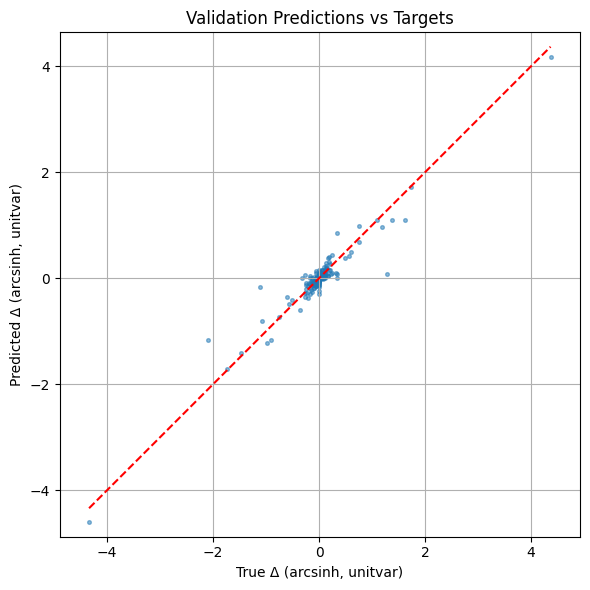

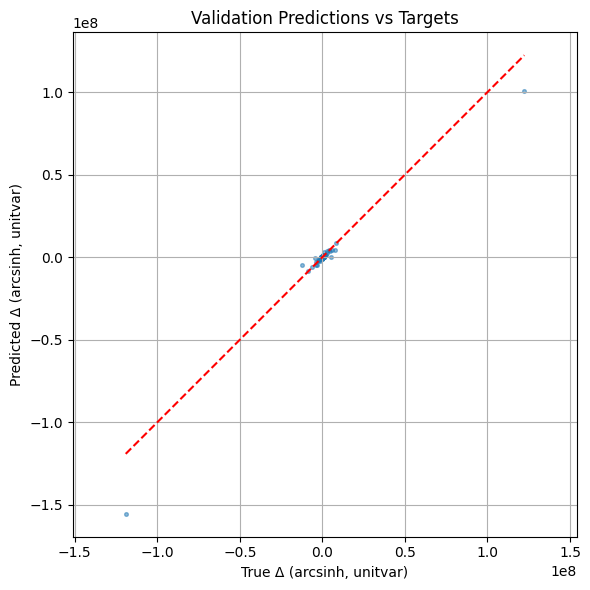

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6, 6))
# Data is shuffled so we might still use the last batch from above
y_batch_np = y_batch.cpu().flatten()
y_batch_og_np = y_batch_og.cpu().flatten()

plt.scatter(y_batch_np, y_pred_transformed.detach().cpu().numpy().flatten(), alpha = 0.5, s = 7)
plt.plot([y_batch_np.min(), y_batch_np.max()], [y_batch_np.min(), y_batch_np.max()], 'r--')  # ideal line
plt.xlabel('True Δ (arcsinh, unitvar)')
plt.ylabel('Predicted Δ (arcsinh, unitvar)')
plt.title('Validation Predictions vs Targets')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize = (6, 6))
plt.scatter(y_batch_og_np, y_pred_og.cpu().numpy().flatten(), alpha = 0.5, s = 7)
plt.plot([y_batch_og_np.min(), y_batch_og_np.max()], [y_batch_og_np.min(), y_batch_og_np.max()], 'r--')  # ideal line
plt.xlabel('True Δ (arcsinh, unitvar)')
plt.ylabel('Predicted Δ (arcsinh, unitvar)')
plt.title('Validation Predictions vs Targets')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

# BC model

- input is arcsinh unitvariance
- output is arcsinh unitvariance

In [56]:
species = 'bc'

############
### test ###
############


# need features to initialize the model: bc has 4 columns
in_feat = globals()[f"x_train_{species}_arcsinh_unitvar"].shape[-1]
out_feat = globals()[f"y_delta_train_{species}_arcsinh_unitvar"].shape[-1]

model = TransitionMatrix(in_features = in_feat, out_features = in_feat, width = 2).double().to(device)

In [57]:
model_path = f"models/arcsinh_unitvar_transition_{species}_10epochs.pth"

checkpoint = torch.load(model_path)
# print(checkpoint.keys())

model.load_state_dict(torch.load(model_path))
# Evaluate
model.eval()

# training did not use x_test_so4_arcsinh_unitvar yet
x_test = globals()[f"x_test_{species}_arcsinh_unitvar"]
y_test = globals()[f"y_delta_test_{species}_arcsinh_unitvar"]

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

r2_transformed = []
r2_og = []
rmse_transformed = []
rmse_og = []

for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
    # Move data to device
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    y_batch_og = torch.sinh(y_batch) * globals()[f"std_y_delta_val_{species}"]

    # Forward pass
    with torch.no_grad():
        y_pred_transformed = model(x_batch)

    y_pred_og = torch.sinh(y_pred_transformed) * globals()[f"std_y_delta_val_{species}"]

    r2_transformed_batch = r2(y_pred_transformed, y_batch).item()
    r2_og_batch = r2(y_pred_og, y_batch_og).item()

    rmse_transformed_batch = torch.sqrt(F.mse_loss(y_pred_transformed, y_batch)).item()
    rmse_og_batch = torch.sqrt(F.mse_loss(y_pred_og, y_batch_og)).item()

    r2_transformed.append(r2_transformed_batch)
    r2_og.append(r2_og_batch)
    rmse_transformed.append(rmse_transformed_batch)
    rmse_og.append(rmse_og_batch)

/tmp/ipykernel_416722/34936905.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
/tmp/ipykernel_416722/34936905.py:6: FutureWarning: Yo

In [58]:
print(np.mean(r2_transformed), np.mean(r2_og), np.mean(rmse_transformed), np.mean(rmse_og))

-29901.244146162633 -209098.00362195773 0.11886662062501249 0.02786894130189754


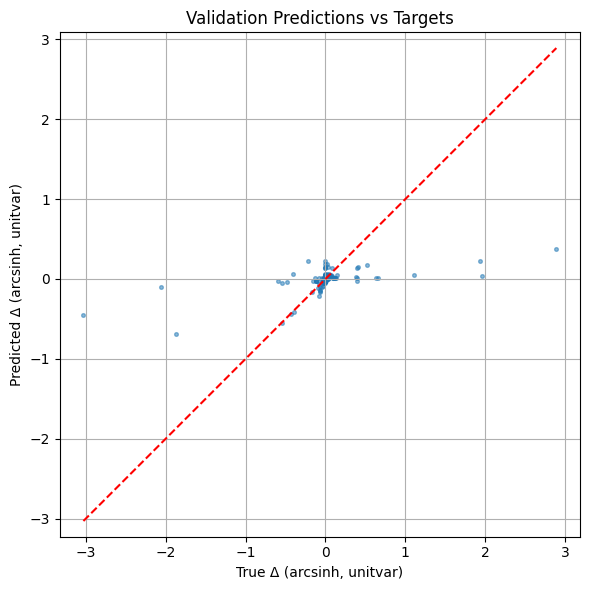

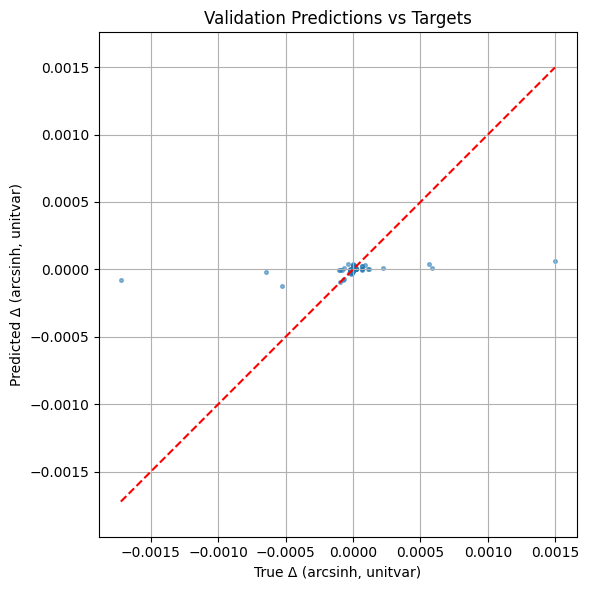

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6, 6))
# Data is shuffled so we might still use the last batch from above
y_batch_np = y_batch.cpu().flatten()
y_batch_og_np = y_batch_og.cpu().flatten()

plt.scatter(y_batch_np, y_pred_transformed.detach().cpu().numpy().flatten(), alpha = 0.5, s = 7)
plt.plot([y_batch_np.min(), y_batch_np.max()], [y_batch_np.min(), y_batch_np.max()], 'r--')  # ideal line
plt.xlabel('True Δ (arcsinh, unitvar)')
plt.ylabel('Predicted Δ (arcsinh, unitvar)')
plt.title('Validation Predictions vs Targets')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize = (6, 6))
plt.scatter(y_batch_og_np, y_pred_og.cpu().numpy().flatten(), alpha = 0.5, s = 7)
plt.plot([y_batch_og_np.min(), y_batch_og_np.max()], [y_batch_og_np.min(), y_batch_og_np.max()], 'r--')  # ideal line
plt.xlabel('True Δ (arcsinh, unitvar)')
plt.ylabel('Predicted Δ (arcsinh, unitvar)')
plt.title('Validation Predictions vs Targets')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
data_split = ['train', 'val', 'test']

for species, indices in species_indices.items():
    # Iterate over data splits (train, val, test)
    for split in data_split:
        y = globals()[f'y_delta_{split}_{species}_arcsinh']
        print(f"Mean {species} {split} arcsinh  std: {y.std()}")
        print(f"Mean {species} {split} arcsinh mean: {y.mean()}")

Mean so4 train arcsinh  std: 8.381096703906225
Mean so4 train arcsinh mean: 0.9466175940934604
Mean so4 val arcsinh  std: 8.25004533798926
Mean so4 val arcsinh mean: 1.016889374539846
Mean so4 test arcsinh  std: 8.3231043195562
Mean so4 test arcsinh mean: 1.0469861910460043
Mean bc train arcsinh  std: 0.00023486543649868467
Mean bc train arcsinh mean: 2.2516527624887637e-11
Mean bc val arcsinh  std: 0.00016682728953130223
Mean bc val arcsinh mean: 1.0507090128822376e-11
Mean bc test arcsinh  std: 0.00015682518390395
Mean bc test arcsinh mean: 1.1278377225049547e-11
Mean oc train arcsinh  std: 0.0005767884754975627
Mean oc train arcsinh mean: -9.180231296872685e-11
Mean oc val arcsinh  std: 0.0004764852185866295
Mean oc val arcsinh mean: -4.795526580350231e-11
Mean oc test arcsinh  std: 0.00044527883832349506
Mean oc test arcsinh mean: -1.953639004419232e-12
Mean du train arcsinh  std: 0.010043062984313669
Mean du train arcsinh mean: -1.2470785338270686e-09
Mean du val arcsinh  std: 0.0

: 

In [ ]:
y_delta_test_so4.mean(-1)

y_delta_test_so4

tensor(1.0206e+09, dtype=torch.float64)